In [ ]:
!pip install dash-core-components==2.0.0
!pip install dash-table==5.0.0
!pip install dash==2.9.3
!pip install -Uqq dash-html-components==2.0.0
!pip install -Uqq portalocker>=2.0.0
!pip install -qq torchtext
!pip install -qq torchdata
!pip install -Uqq plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 59.0 MB/s eta 0:00:00


In [ ]:
def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn

from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
import plotly.graph_objs as go
import pickle

from torch.nn.utils.rnn import pad_sequence

In [ ]:
def plot(COST,ACC):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [ ]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [ ]:
def plot_tras(words, model):
    # Tokenize the input words using a tokenizer function
    tokens = tokenizer(words)

    # Define the model's embedding dimension (d_model)
    d_model = 100

    # Convert the input words to a PyTorch tensor and move it to the specified device
    x = torch.tensor(text_pipeline(words)).unsqueeze(0).to(device)

    # Apply the model's embedding layer and scale the embeddings by sqrt(d_model)
    x_ = model.emb(x) * math.sqrt(d_model)

    # Apply the model's positional encoder to the embeddings
    x = model.pos_encoder(x_)

    # Extract projection weights for query, key, and value from the model's state_dict
    q_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][0:embed_dim].t()
    k_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][embed_dim:2*embed_dim].t()
    v_proj_weight = model.state_dict()['transformer_encoder.layers.0.self_attn.in_proj_weight'][2*embed_dim:3*embed_dim].t()

    # Calculate query (Q), key (K), and value (V) matrices
    Q = (x @ q_proj_weight).squeeze(0)
    K = (x @ k_proj_weight).squeeze(0)
    V = (x @ v_proj_weight).squeeze(0)

    # Calculate attention scores using dot-product attention
    scores = Q @ K.T

    # Set row and column labels for the attention matrix
    row_labels = tokens
    col_labels = row_labels

    # Create a heatmap of the attention scores
    plt.figure(figsize=(10, 8))
    plt.imshow(scores.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Dot-Product Attention")
    plt.show()

    # Apply softmax to the attention scores and create a heatmap
    att = nn.Softmax(dim=1)(scores)
    plt.figure(figsize=(10, 8))
    plt.imshow(att.cpu().detach().numpy())
    plt.yticks(range(len(row_labels)), row_labels)
    plt.xticks(range(len(col_labels)), col_labels, rotation=90)
    plt.title("Scaled Dot-Product Attention")
    plt.show()

    # Calculate the attention head by multiplying softmax scores with values (V)
    head = nn.Softmax(dim=1)(scores) @ V

    # Visualize the embeddings and attention heads using t-SNE
    tsne(x_, tokens, title="Embeddings")
    tsne(head, tokens, title="Attention Heads")


def tsne(embeddings, tokens, title="Embeddings"):
    # Initialize t-SNE with 2 components and a fixed random state
    tsne = TSNE(n_components=2, random_state=0)

    # Fit t-SNE to the embeddings (converting from GPU if necessary)
    tsne_result = tsne.fit_transform(embeddings.squeeze(0).cpu().detach().numpy())

    # Create a scatter plot of the t-SNE results
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])

    # Set a title for the plot
    plt.title(title)

    # Add labels for each point in the scatter plot
    for j, label in enumerate(tokens):
        # Place the label text at the corresponding t-SNE coordinates
        plt.text(tsne_result[j, 0], tsne_result[j, 1], label)

    plt.show()

In [ ]:
def save_list_to_file(lst, filename):
    """
    Save a list to a file using pickle serialization.

    Parameters:
        lst (list): The list to be saved.
        filename (str): The name of the file to save the list to.

    Returns:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Load a list from a file using pickle deserialization.

    Parameters:
        filename (str): The name of the file to load the list from.

    Returns:
        list: The loaded list.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

In [ ]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]
tokenizer = get_tokenizer('basic_english') # We define a tokenizer with basic_english. This will split the text using whitespace and punctuation

# A function which will take the dataset and iterate through the texts and return the split list for each sentence
def yield_tokens(data_iter):
  for _, text in data_iter:
    # Instead of returning one value and terminating, this will return multiple values
    yield tokenizer(text)
vocab = build_vocab_from_iterator(yield_tokens(dataset), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
def text_pipeline(x):
  return vocab(tokenizer(x))
def label_pipeline(x):
  return int(x) - 1

In [ ]:
# In numerous pytorch applications, it is necessary to ensure that the batch sizes are consistent. We will use pad_sequence to make sure that each sequence is of the same length
sequences = [torch.tensor([j for j in range(1,i)]) for i in range(2,10)]
sequences

[tensor([1]),
 tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8])]

In [ ]:
padded_sequences = pad_sequence(sequences, batch_first = True, padding_value = 0)
# Notice the input is a list of tensors, whereas the output is just one tensor where the outputs are stacked
print(padded_sequences)

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 2, 0, 0, 0, 0, 0, 0],
        [1, 2, 3, 0, 0, 0, 0, 0],
        [1, 2, 3, 4, 0, 0, 0, 0],
        [1, 2, 3, 4, 5, 0, 0, 0],
        [1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])


In [ ]:
my_tokens='he painted the car red he painted the red car'

my_index = text_pipeline(my_tokens)
my_index

embedding_dim = 3

vocab_size = len(vocab)
print("Vocabulary size: ", vocab_size)

embedding = nn.Embedding(vocab_size, embedding_dim)

Vocabulary size:  27


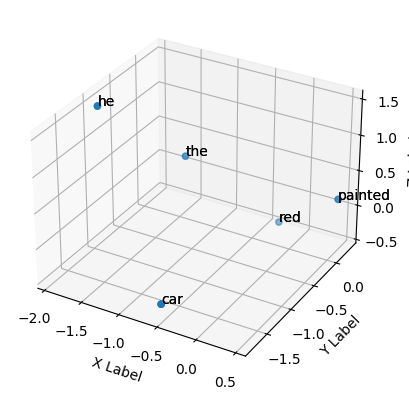

In [ ]:
my_embeddings = embedding(torch.tensor(my_index)).detach().numpy()
plot_embdings(my_embeddings, tokenizer(my_tokens), vocab)

In [ ]:
# We can see that the encodings are not affected by the position of words in the sequence. This means that if a word comes first or last it will have the same embedding.
# Thus we need to include some information about the position of the word in the sequence as well
position = torch.arange(1, vocab_size, 1).view(-1,1)
position

tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [20],
        [21],
        [22],
        [23],
        [24],
        [25],
        [26]])

In [ ]:
d_model = 3
pe = torch.zeros(vocab_size, d_model)
pe

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
pe = torch.cat((position,position,position), 1)
pe

tensor([[ 1,  1,  1],
        [ 2,  2,  2],
        [ 3,  3,  3],
        [ 4,  4,  4],
        [ 5,  5,  5],
        [ 6,  6,  6],
        [ 7,  7,  7],
        [ 8,  8,  8],
        [ 9,  9,  9],
        [10, 10, 10],
        [11, 11, 11],
        [12, 12, 12],
        [13, 13, 13],
        [14, 14, 14],
        [15, 15, 15],
        [16, 16, 16],
        [17, 17, 17],
        [18, 18, 18],
        [19, 19, 19],
        [20, 20, 20],
        [21, 21, 21],
        [22, 22, 22],
        [23, 23, 23],
        [24, 24, 24],
        [25, 25, 25],
        [26, 26, 26]])

In [ ]:
# You only need the positional encodings for the sequence length
samples, dim = my_embeddings.shape
print(samples, dim)

10 3


In [ ]:
pos_embedding = my_embeddings + pe[:samples].numpy()
pos_embedding

array([[-0.91817772,  0.02333921,  2.48132885],
       [ 2.44934842,  2.304187  ,  2.1253837 ],
       [ 1.71671689,  2.80193022,  3.52084124],
       [ 3.45208961,  2.22023261,  3.6505689 ],
       [ 4.70407262,  5.2584272 ,  4.58480588],
       [ 4.08182228,  5.02333921,  7.48132885],
       [ 7.44934842,  7.304187  ,  7.1253837 ],
       [ 6.71671689,  7.80193022,  8.52084124],
       [ 8.70407262,  9.2584272 ,  8.58480588],
       [ 9.45208961,  8.22023261,  9.6505689 ]])

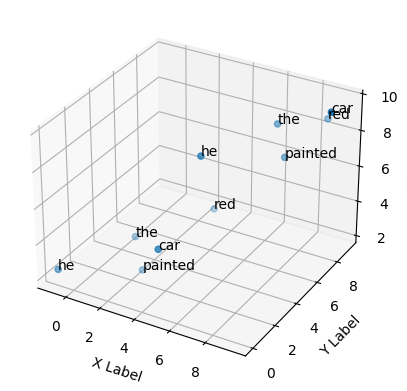

In [ ]:
plot_embdings(pos_embedding, tokenizer(my_tokens), vocab)

In [ ]:
# One problem with this is that as the sequence length increases, the words later in the sequence have embeddings which are bigger in magnitude.
pe = torch.cat(((torch.cos(2 * np.pi * position / 25)), (torch.sin(2 * np.pi * position / 25)), (torch.sin(2 * np.pi * position / 5))), 1)
pe

tensor([[ 9.6858e-01,  2.4869e-01,  9.5106e-01],
        [ 8.7631e-01,  4.8175e-01,  5.8779e-01],
        [ 7.2897e-01,  6.8455e-01, -5.8779e-01],
        [ 5.3583e-01,  8.4433e-01, -9.5106e-01],
        [ 3.0902e-01,  9.5106e-01,  1.7485e-07],
        [ 6.2790e-02,  9.9803e-01,  9.5106e-01],
        [-1.8738e-01,  9.8229e-01,  5.8778e-01],
        [-4.2578e-01,  9.0483e-01, -5.8779e-01],
        [-6.3742e-01,  7.7051e-01, -9.5106e-01],
        [-8.0902e-01,  5.8779e-01,  3.4969e-07],
        [-9.2978e-01,  3.6812e-01,  9.5106e-01],
        [-9.9211e-01,  1.2533e-01,  5.8778e-01],
        [-9.9211e-01, -1.2533e-01, -5.8779e-01],
        [-9.2978e-01, -3.6812e-01, -9.5106e-01],
        [-8.0902e-01, -5.8779e-01,  4.7700e-08],
        [-6.3742e-01, -7.7051e-01,  9.5106e-01],
        [-4.2578e-01, -9.0483e-01,  5.8778e-01],
        [-1.8738e-01, -9.8229e-01, -5.8779e-01],
        [ 6.2791e-02, -9.9803e-01, -9.5106e-01],
        [ 3.0902e-01, -9.5106e-01,  6.9938e-07],
        [ 5.3583e-01

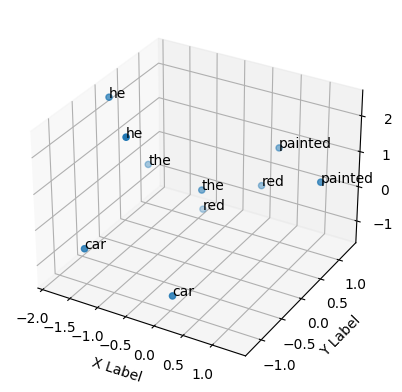

In [ ]:
pos_embedding = my_embeddings + pe[:samples].numpy()
plot_embdings(pos_embedding, tokenizer(my_tokens), vocab)

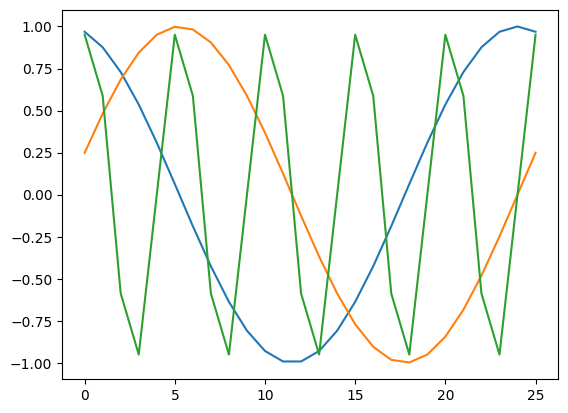

In [ ]:
plt.plot(pe[:, 0].numpy(), label="Dimension 1")
plt.plot(pe[:, 1].numpy(), label="Dimension 2")
plt.plot(pe[:, 2].numpy(), label="Dimension 3")

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, vocab_size = 5000, dropout = 0.1):
    super().__init__()
    self.dropout = nn.Dropout(p = dropout)
    pe = torch.zeros(vocab_size, d_model)
    position = torch.arange(0, vocab_size, dtype = torch.float).unsqueeze(1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
  def forward(self, x):
    x = x + self.pe[:, : x.size(1), :]
    return self.dropout(x)

In [ ]:
my_embdings = embedding(torch.tensor(my_index))
my_embdings

tensor([[-1.9182, -0.9767,  1.4813],
        [ 0.4493,  0.3042,  0.1254],
        [-1.2833, -0.1981,  0.5208],
        [-0.5479, -1.7798, -0.3494],
        [-0.2959,  0.2584, -0.4152],
        [-1.9182, -0.9767,  1.4813],
        [ 0.4493,  0.3042,  0.1254],
        [-1.2833, -0.1981,  0.5208],
        [-0.2959,  0.2584, -0.4152],
        [-0.5479, -1.7798, -0.3494]], grad_fn=<EmbeddingBackward0>)

In [ ]:
my_embdings.shape

torch.Size([10, 3])

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model = 3,
                                           nhead = 1,
                                           dim_feedforward = 1,
                                           dropout = 0)

In [ ]:
out = encoder_layer(my_embdings)
out

tensor([[-0.6470, -0.7656,  1.4125],
        [ 0.2241, -1.3213,  1.0972],
        [-0.8651, -0.5363,  1.4014],
        [-0.0273, -1.2109,  1.2382],
        [-1.4122,  0.6412,  0.7710],
        [-0.6470, -0.7656,  1.4125],
        [ 0.2241, -1.3213,  1.0972],
        [-0.8651, -0.5363,  1.4014],
        [-1.4122,  0.6412,  0.7710],
        [-0.0273, -1.2109,  1.2382]], grad_fn=<NativeLayerNormBackward0>)

In [ ]:
out.mean(dim = 1)

tensor([-3.9736e-08,  3.9736e-08,  0.0000e+00,  7.9473e-08,  5.9605e-08,
        -3.9736e-08,  3.9736e-08,  0.0000e+00,  5.9605e-08,  7.9473e-08],
       grad_fn=<MeanBackward1>)

In [ ]:
params_dict = encoder_layer.state_dict()
for name, param in params_dict.items():
  print(f'Name : {name} and value is: {param}')

Name : self_attn.in_proj_weight and value is: tensor([[-0.4589,  0.4438,  0.1233],
        [-0.5445,  0.2350,  0.4627],
        [-0.0023,  0.5304,  0.1548],
        [ 0.0300,  0.4477,  0.6147],
        [ 0.5656, -0.3500, -0.5722],
        [ 0.2971,  0.3654, -0.3759],
        [ 0.2400,  0.5666, -0.4311],
        [-0.1854, -0.3398,  0.0342],
        [-0.2279, -0.2970, -0.0181]])
Name : self_attn.in_proj_bias and value is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Name : self_attn.out_proj.weight and value is: tensor([[-0.0022,  0.4803, -0.1039],
        [ 0.5026,  0.2200, -0.3329],
        [-0.4351, -0.1178,  0.5067]])
Name : self_attn.out_proj.bias and value is: tensor([0., 0., 0.])
Name : linear1.weight and value is: tensor([[ 0.2292, -0.4070, -0.3012]])
Name : linear1.bias and value is: tensor([0.4659])
Name : linear2.weight and value is: tensor([[-0.3618],
        [ 0.7526],
        [ 0.8372]])
Name : linear2.bias and value is: tensor([0.9493, 0.3694, 0.9548])
Name : norm1.weight 

In [ ]:
embed_dim = 3
q_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][0:embed_dim].t()
k_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][embed_dim : 2 * embed_dim].t()
v_proj_weight = encoder_layer.state_dict()['self_attn.in_proj_weight'][2 * embed_dim : 3 * embed_dim].t()

In [ ]:
Q = my_embdings @ q_proj_weight
K = my_embdings @ k_proj_weight
V = my_embdings @ v_proj_weight

In [ ]:
scores = Q @ K.T / np.sqrt(embed_dim)
scores

tensor([[-0.9832,  0.1157, -0.6500,  0.1828, -0.0982, -0.9832,  0.1157, -0.6500,
         -0.0982,  0.1828],
        [-0.0615,  0.0081, -0.0101, -0.0718,  0.0230, -0.0615,  0.0081, -0.0101,
          0.0230, -0.0718],
        [-0.6662,  0.1107, -0.4212, -0.0624, -0.0609, -0.6662,  0.1107, -0.4212,
         -0.0609, -0.0624],
        [ 0.9728, -0.2021,  0.4641,  0.6541, -0.0405,  0.9728, -0.2021,  0.4641,
         -0.0405,  0.6541],
        [-0.0424,  0.0358, -0.0218, -0.1384, -0.0105, -0.0424,  0.0358, -0.0218,
         -0.0105, -0.1384],
        [-0.9832,  0.1157, -0.6500,  0.1828, -0.0982, -0.9832,  0.1157, -0.6500,
         -0.0982,  0.1828],
        [-0.0615,  0.0081, -0.0101, -0.0718,  0.0230, -0.0615,  0.0081, -0.0101,
          0.0230, -0.0718],
        [-0.6662,  0.1107, -0.4212, -0.0624, -0.0609, -0.6662,  0.1107, -0.4212,
         -0.0609, -0.0624],
        [-0.0424,  0.0358, -0.0218, -0.1384, -0.0105, -0.0424,  0.0358, -0.0218,
         -0.0105, -0.1384],
        [ 0.9728, -

In [ ]:
head = nn.Softmax(dim = 1)(scores)@V
head

tensor([[-0.4018,  0.2499,  0.2453],
        [-0.5364,  0.2919,  0.2887],
        [-0.4102,  0.2389,  0.2362],
        [-0.8656,  0.4546,  0.4415],
        [-0.5358,  0.2881,  0.2847],
        [-0.4018,  0.2499,  0.2453],
        [-0.5364,  0.2919,  0.2887],
        [-0.4102,  0.2389,  0.2362],
        [-0.5358,  0.2881,  0.2847],
        [-0.8656,  0.4546,  0.4415]], grad_fn=<MmBackward0>)

In [ ]:
train_iter = AG_NEWS(split = 'train')
train_iter

ShardingFilterIterDataPipe

In [ ]:
y, text = next(iter(train_iter))
print(f'y: {y} text: {text}')

y: 3 text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [ ]:
ag_news_label = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tec'}
ag_news_label[y]

'Business'

In [ ]:
num_class = len(set([label for label, text in train_iter]))
num_class

4

In [ ]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
train_iter, test_iter = AG_NEWS()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [ ]:
num_train = int(len(train_dataset) * 0.95)  # Reserving 95% of the training dataset for training and the remaining 5% for validation
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [ ]:
def text_pipeline(x):
  return vocab(tokenizer(x))
def label_pipeline(x):
  return int(x) - 1

In [ ]:
def collate_batch(batch):
  label_list, text_list = [], []
  for _label, _text in batch:
    label_list.append(label_pipeline(_label))
    text_list.append(torch.tensor(text_pipeline(_text), dtype = torch.int64))

  label_list = torch.tensor(label_list, dtype = torch.int64)
  text_list = pad_sequence(text_list, batch_first = True)

  return label_list.to(device), text_list.to(device)

In [ ]:
BATCH_SIZE = 64

train_dataloader = DataLoader(dataset = split_train_, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

valid_dataloader = DataLoader(dataset = split_valid_, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_batch)

In [ ]:
label, sequence = next(iter(train_dataloader))
sequence.size()

torch.Size([64, 63])

In [ ]:
class Net(nn.Module):
  def __init__(
      self,
      vocab_size,
      num_class,
      embedding_dim = 100,
      nhead = 5,
      dim_feedforward = 2048,
      num_layers = 6,
      dropout = 0.1,
      activation = 'relu',
      classifier_dropout = 0.1):

    super().__init__()
    self.emb = nn.Embedding(vocab_size, embedding_dim)

    self.pos_encoder = PositionalEncoding(embedding_dim, vocab_size, dropout)

    encoder_layer = nn.TransformerEncoderLayer(
        d_model = embedding_dim,
        nhead = nhead,
        dim_feedforward = dim_feedforward,
        dropout = dropout
    )
    self.transformer_encoder = nn.TransformerEncoder(
        encoder_layer = encoder_layer, num_layers = num_layers
    )
    self.classifier = nn.Linear(embedding_dim, num_class)
    self.d_model = embedding_dim

  def forward(self, x):
    x = self.emb(x) * math.sqrt(self.d_model)
    x = self.pos_encoder(x)
    x = self.transformer_encoder(x)
    x = x.mean(dim = 1)
    x = self.classifier(x)

    return x

In [ ]:
y, x = next(iter(train_dataloader))
x

tensor([[   77,     4,  2264,  ...,     0,     0,     0],
        [   51,     1,   137,  ...,     0,     0,     0],
        [12692,  1218,  5085,  ...,     0,     0,     0],
        ...,
        [ 4892,  4801,    42,  ...,     0,     0,     0],
        [  466,   622,   605,  ...,     0,     0,     0],
        [ 6178,  3070,     4,  ...,     0,     0,     0]])

In [ ]:
vocab_size = len(vocab)
vocab_size

95811

In [ ]:
model = Net(vocab_size = vocab_size, num_class = 4).to(device)
model

Net(
  (emb): Embedding(95811, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
model(x).size()

torch.Size([64, 4])

In [ ]:
def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.unsqueeze(torch.tensor(text_pipeline(text)), 0).to(device)
    output = model(text)
  return ag_news_label[output.argmax(1).item() + 1]

In [ ]:
predict("I like sports and stuff",text_pipeline )

'Sports'

In [ ]:
def evaluate(dataloader, model_eval):
    model_eval.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model_eval(text.to(device))

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [ ]:
evaluate(test_dataloader, model)

0.2503947368421053

In [ ]:
LR = 0.1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
epochs = 10
cum_loss_list = []
acc_epoch = []
acc_old = []

for epoch in tqdm(range(1, epochs + 1)):
  model.train()
  cum_loss = 0
  for idx, (label, text) in enumerate(train_dataloader):
    optimizer.zero_grad()
    label, text = label.to(device), text.to(device)
    predicted_label = model(text)
    loss = criterion(predicted_label, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    cum_loss += loss.item()
  print('loss', cum_loss)
  cum_loss_list.append(cum_loss)
  accu_val = evaluate(valid_dataloader)
  acc_epoch.append(accu_val)

  0%|          | 0/10 [1:50:53<?, ?it/s]


KeyboardInterrupt: 